In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table, join, Column
from astropy.stats import LombScargle
import astropy.units as u                          # We'll need this later.

from astropy.io import ascii
import glob, re, copy
from hot_utils import *

from lightkurve import KeplerLightCurveFile, KeplerLightCurve

% matplotlib inline

import matplotlib as mpl
mpl.style.use('seaborn-colorblind')

#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=20               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
from matplotlib import rc

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']


### Load a cool Kepler object - an oscillating star with a putative planet as found by [Sowicka et al](http://adsabs.harvard.edu/abs/2017MNRAS.467.4663S), 2017.

In [2]:
lcs = KeplerLightCurveFile.from_archive(8197761,quarter='all',cadence='long')
quarters = np.array([])
for j, lci in enumerate(lcs):
    lci = lci.get_lightcurve('PDCSAP_FLUX').remove_nans()
    lci = lci[lci.quality==0]
    lcs[j] = lci.normalize()
    quarters = np.append(quarters,lci.quarter*np.ones_like(lci.flux))


lc = lcs[0]
lc.quarter = quarters
for lci in lcs[1:]:
    lc = lc.append(lci)

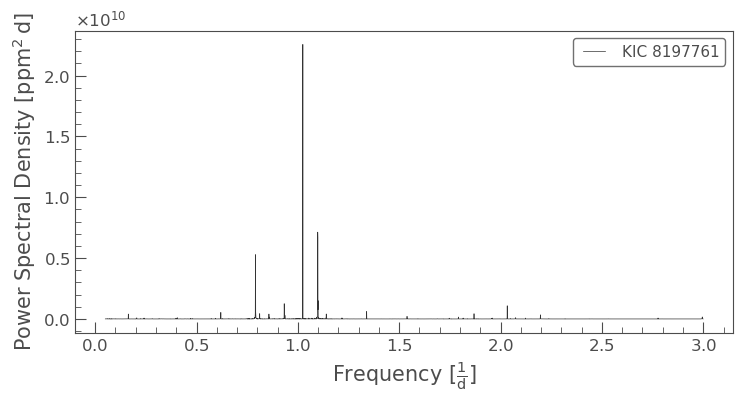

In [3]:
pg = lc.to_periodogram(min_period=8./24.*u.day, max_period=20.*u.day)
pg.plot();


### Run an iterative sine-fitting algorithm to subtract out the stellar signal

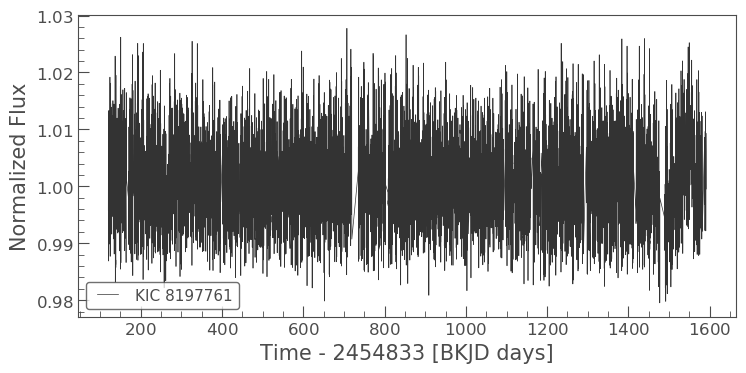

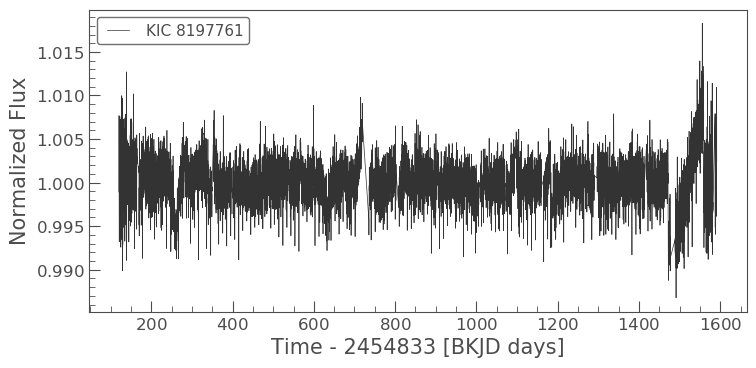

In [18]:
lc = lcs[0]
for lci in lcs[1:]:
    lc = lc.append(lci)
lc.plot()

lc2 = copy.copy(lc)
ff, pp, noise = [], [], []
y_fit = 0

for j in range(80):
    pg = lc2.to_periodogram(min_period=4./24.*u.day, max_period=30.*u.day)
    ff.append(pg.frequency_at_max_power.value)
    pp.append(pg.max_power.value)
    y_fit += LombScargle(lc2.time, lc2.flux-1, lc2.flux_err).model(lc2.time, pg.frequency_at_max_power.value)
    lc2.flux = lc.flux - y_fit 
    noise.append(lc2.estimate_cdpp())
    
lc2.plot()

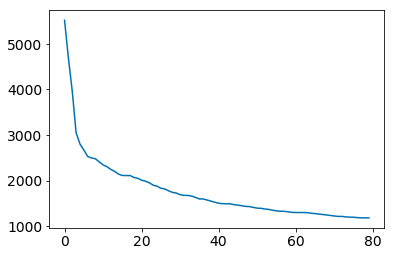

In [41]:
plt.plot(noise)

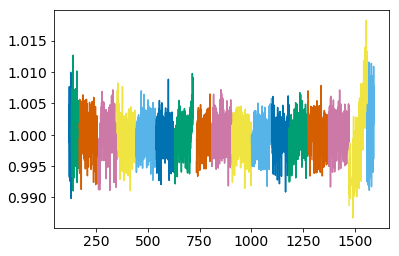

In [19]:
for q in range(18):
    m = (lc.quarter==q)
#     plt.plot(lc.time[m],lc.flux[m],'.')
    plt.plot(lc.time[m],lc2.flux[m],'-')

    

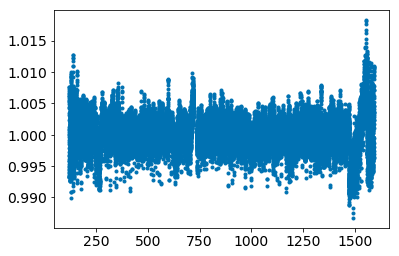

In [20]:
# lc2=lc2.flatten()
# plt.plot(lc.time,lc.flux,'.')
plt.plot(lc.time,lc2.flux,'.')

# plt.xlim(500,900)

### What does the raw light curve look like on a planet?

In [21]:
planet_period = 9.8686667
folded = lc.fold(planet_period)
binned = folded.bin(binsize=25,method='median')

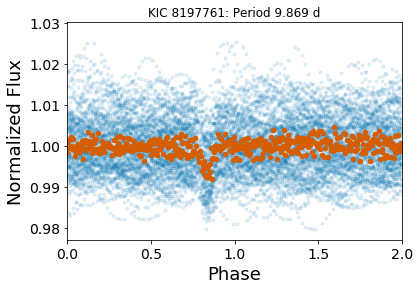

In [22]:
plt.plot(folded.phase*planet_period,folded.flux,'.',alpha=0.1)
plt.plot(binned.phase*planet_period,binned.flux,'.',markersize=9,color=colours[2])
plt.xlim(0,2)
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
plt.title('KIC %d: Period %.3f d' % (lc.targetid,planet_period))
plt.savefig('oscillator_with_planets.png')

### Now use the Oxford systematics correction

In [23]:
lc3 = copy.copy(lc2)

for qq in np.unique(lc2.quarter.astype('int')):
    print qq
    m = lc3.quarter==qq
    lc3.flux[m] = correct_quarter(lc2,qq)
    
print 'Done'

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
Done


## Now do a BLS search to find it

In [24]:
from pybls import BLS


In [25]:
bls = BLS(lc3.time, lc3.flux, lc3.flux_err/10., period_range=(1,40), q_range=(0.001, 0.01), nf=4500, nbin=2000)


In [26]:
res = bls()

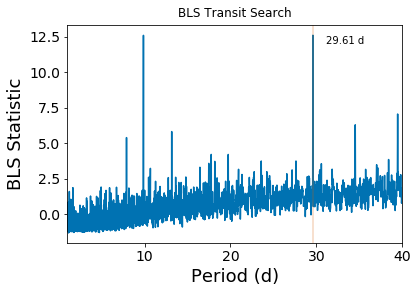

In [27]:
plt.plot(bls.period,bls.sde)
for j in range(np.round(bls.period.max()/res.bper).astype('int')):
    plt.axvline(res.bper*(j+1),alpha=0.25,color=colours[2])
plt.text(res.bper*1.05,bls.sde.max()*0.95,'%.2f d' % res.bper)
plt.xlim(bls.period.min(),bls.period.max())
plt.xlabel('Period (d)')
plt.ylabel('BLS Statistic')
plt.title('BLS Transit Search',y=1.01)
plt.savefig('bls_%d.png' %  lc.targetid)

### Now refine it

In [37]:
bls = BLS(lc3.time, lc3.flux, lc3.flux_err, period_range=(res.bper*0.98,res.bper*1.02), q_range=(0.001, 0.01), nf=4500, nbin=2000)
res = bls()

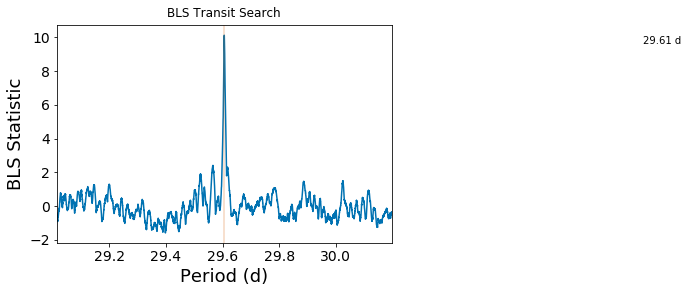

In [38]:
plt.plot(bls.period,bls.sde)
for j in range(np.round(bls.period.max()/res.bper).astype('int')):
    plt.axvline(res.bper*(j+1),alpha=0.25,color=colours[2])
plt.text(res.bper*1.05,bls.sde.max()*0.95,'%.2f d' % res.bper)
plt.xlim(bls.period.min(),bls.period.max())
plt.xlabel('Period (d)')
plt.ylabel('BLS Statistic')
plt.title('BLS Transit Search',y=1.01)
plt.savefig('bls_%d.png' %  lc.targetid)

### Plot the folded light curve

In [39]:
planet_period = 9.8686667 # literature
planet_period = res.bper
folded = lc3.fold(planet_period)
binned = folded.bin(binsize=25,method='median')
folded = lc3.fold(planet_period)
binned = folded.bin(binsize=25,method='median')

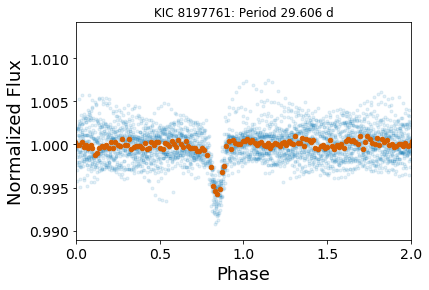

In [40]:
plt.plot(folded.phase*planet_period,folded.flux,'.',alpha=0.1)
plt.plot(binned.phase*planet_period,binned.flux,'.',markersize=9,color=colours[2])
plt.xlim(0,2)
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
plt.title('KIC %d: Period %.3f d' % (lc.targetid,planet_period))
plt.savefig('oscillator_with_planets.png')